# Flow Curve Protocol Validation

**Validates flow curve data: σ vs γ̇ (shear stress vs shear rate)**

## Protocol Description

Flow curves measure the steady-state relationship between shear stress (σ) and shear rate (γ̇).
The apparent viscosity is derived as η = σ/γ̇.

## Validation Checks

1. **Schema validation**: Required columns present (shear rate, stress)
2. **Finite values**: No NaN or Inf in data arrays
3. **Positive shear rate**: γ̇ > 0 (strictly positive)
4. **Non-negative stress**: σ ≥ 0
5. **Shear-thinning check**: Viscosity decreases with shear rate (warning if violated)

## Standard Plots

- σ vs γ̇ (log-log)
- η vs γ̇ (log-log)

In [1]:
# Configuration
MODE = "FAST"  # "FAST" or "FULL"

if MODE == "FAST":
    MAX_FILES = 2
    SKIP_HEAVY_PLOTS = True
    SAVE_ARTIFACTS = False
else:
    MAX_FILES = None  # all files
    SKIP_HEAVY_PLOTS = False
    SAVE_ARTIFACTS = True

print(f"Running in {MODE} mode")

Running in FAST mode


In [2]:
from pathlib import Path
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add project root to path for imports
project_root = Path.cwd()
while not (project_root / "pyproject.toml").exists() and project_root != project_root.parent:
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from examples.verification.utils.validation_utils import (
    DatasetValidation,
    ValidationResult,
    check_finite,
    check_monotonic,
    check_positive,
    compute_flow_derived,
    create_output_directories,
    discover_files_by_protocol,
    get_data_dir,
    load_csv_flexible,
    plot_flow_curve,
    print_validation_summary,
    validate_schema,
    write_validation_report,
)

print(f"Project root: {project_root}")

Project root: /Users/b80985/Projects/rheojax


## A) Dataset Inventory

In [3]:
data_dir = get_data_dir()
files = discover_files_by_protocol(data_dir, "flow_curve")

print(f"Found {len(files)} flow curve data files:")
for i, f in enumerate(files):
    print(f"  {i+1}. {f.relative_to(data_dir)}")

# Limit files in FAST mode
if MAX_FILES is not None:
    files = files[:MAX_FILES]
    print(f"\nProcessing {len(files)} files (FAST mode)")

Found 19 flow curve data files:
  1. flow/emulsions/0.69.csv
  2. flow/emulsions/0.70.csv
  3. flow/emulsions/0.72.csv
  4. flow/emulsions/0.74.csv
  5. flow/emulsions/0.76.csv
  6. flow/emulsions/0.80.csv
  7. flow/hydrogels/cellulose_hydrogel_flow.csv
  8. flow/solutions/ec_shear_viscosity_02-00.csv
  9. flow/solutions/ec_shear_viscosity_03-00.csv
  10. flow/solutions/ec_shear_viscosity_04-00.csv
  11. flow/solutions/ec_shear_viscosity_05-00.csv
  12. flow/solutions/ec_shear_viscosity_06-00.csv
  13. flow/solutions/ec_shear_viscosity_07-00.csv
  14. flow/solutions/ec_shear_viscosity_08-00.csv
  15. flow/solutions/ec_shear_viscosity_09-00.csv
  16. flow/solutions/ec_shear_viscosity_10-00.csv
  17. flow/emulsions/emulsions_v2.csv
  18. flow/hydrogels/rotation_cnf1_data.csv
  19. flow/solutions/rotation_ec07_data.csv

Processing 2 files (FAST mode)


## B) Data Loading and Schema Validation

Flow curve data can have various formats:
- Comma or semicolon separated
- Column names: `Shear Rate`, `Stress`, `Shear Stress`, `Viscosity`
- European decimal format (comma as decimal separator)

In [4]:
def load_flow_curve_data(file_path: Path) -> tuple[np.ndarray, np.ndarray, str]:
    """Load flow curve data with format auto-detection.
    
    Returns:
        Tuple of (gamma_dot, stress, status_message)
    """
    # Try different separators
    for sep in [",", ";", "\t"]:
        try:
            df = pd.read_csv(file_path, sep=sep)
            if len(df.columns) >= 2:
                break
        except Exception:
            continue
    else:
        return None, None, "Could not parse file"
    
    # Skip unit row if present (e.g., [1/s], [Pa])
    if df.iloc[0].astype(str).str.contains(r"\[", regex=True).any():
        df = df.iloc[1:].reset_index(drop=True)
    
    # Find shear rate column
    rate_cols = [c for c in df.columns if "rate" in c.lower() or "shear" in c.lower()]
    stress_cols = [c for c in df.columns if "stress" in c.lower()]
    
    if not rate_cols:
        # Default to first column
        rate_col = df.columns[0]
    else:
        rate_col = rate_cols[0]
    
    if not stress_cols:
        # Default to second column if no stress column found
        stress_col = df.columns[1] if len(df.columns) > 1 else None
        if stress_col is None:
            return None, None, "No stress column found"
    else:
        stress_col = stress_cols[0]
    
    # Convert to numeric (handle European decimal format)
    try:
        gamma_dot = pd.to_numeric(
            df[rate_col].astype(str).str.replace(",", "."),
            errors="coerce"
        ).values
        stress = pd.to_numeric(
            df[stress_col].astype(str).str.replace(",", "."),
            errors="coerce"
        ).values
    except Exception as e:
        return None, None, f"Numeric conversion failed: {e}"
    
    # Remove NaN values
    mask = np.isfinite(gamma_dot) & np.isfinite(stress)
    gamma_dot = gamma_dot[mask]
    stress = stress[mask]
    
    return gamma_dot, stress, f"Loaded {len(gamma_dot)} points from {rate_col}, {stress_col}"

# Test loading first file
if files:
    test_file = files[0]
    gamma_dot, stress, msg = load_flow_curve_data(test_file)
    print(f"Test load: {test_file.name}")
    print(f"  {msg}")
    if gamma_dot is not None:
        print(f"  γ̇ range: [{gamma_dot.min():.2e}, {gamma_dot.max():.2e}] 1/s")
        print(f"  σ range: [{stress.min():.2e}, {stress.max():.2e}] Pa")

Test load: 0.69.csv
  Loaded 29 points from Shear Rate, Stress
  γ̇ range: [1.57e-03, 6.25e+02] 1/s
  σ range: [4.70e+00, 8.07e+01] Pa


## C) Validation Pipeline

In [5]:
def validate_flow_curve(file_path: Path) -> DatasetValidation:
    """Run all validation checks on a flow curve file."""
    validation = DatasetValidation(
        file_path=str(file_path),
        protocol="flow_curve",
    )
    
    # Load data
    gamma_dot, stress, load_msg = load_flow_curve_data(file_path)
    
    if gamma_dot is None:
        validation.results.append(ValidationResult(
            check_name="data_loading",
            passed=False,
            message=load_msg,
        ))
        return validation
    
    validation.results.append(ValidationResult(
        check_name="data_loading",
        passed=True,
        message=load_msg,
        details={"n_points": len(gamma_dot)},
    ))
    
    # Check 1: Finite values
    validation.results.append(check_finite(gamma_dot, "shear_rate"))
    validation.results.append(check_finite(stress, "stress"))
    
    # Check 2: Positive shear rate (strictly > 0)
    validation.results.append(check_positive(gamma_dot, "shear_rate", strict=True))
    
    # Check 3: Non-negative stress (>= 0)
    validation.results.append(check_positive(stress, "stress", strict=False))
    
    # Compute derived quantities
    derived = compute_flow_derived(gamma_dot, stress)
    eta = derived["eta"]
    
    validation.derived_quantities = {
        "gamma_dot": gamma_dot,
        "stress": stress,
        "eta": eta,
    }
    
    # Check 4: Shear-thinning behavior (viscosity decreases with shear rate)
    # Sort by shear rate first
    sort_idx = np.argsort(gamma_dot)
    eta_sorted = eta[sort_idx]
    
    # Check if generally decreasing (allow some noise)
    n_decreasing = np.sum(np.diff(eta_sorted) < 0)
    n_intervals = len(eta_sorted) - 1
    frac_decreasing = n_decreasing / n_intervals if n_intervals > 0 else 0
    
    is_shear_thinning = frac_decreasing > 0.5
    validation.results.append(ValidationResult(
        check_name="shear_thinning",
        passed=True,  # Always pass, just informational
        message=f"Viscosity decreasing in {frac_decreasing*100:.0f}% of intervals"
                + (" (shear-thinning)" if is_shear_thinning else " (Newtonian or shear-thickening)"),
        details={"frac_decreasing": frac_decreasing, "is_shear_thinning": is_shear_thinning},
    ))
    
    return validation

In [6]:
# Run validation on all files
validations = []

for file_path in files:
    print(f"\nValidating: {file_path.name}")
    v = validate_flow_curve(file_path)
    validations.append(v)
    
    # Print results
    for r in v.results:
        status = "PASS" if r.passed else "FAIL"
        print(f"  [{status}] {r.check_name}: {r.message}")


Validating: 0.69.csv
  [PASS] data_loading: Loaded 29 points from Shear Rate, Stress
  [PASS] finite_values_shear_rate: shear_rate: all 29 values finite
  [PASS] finite_values_stress: stress: all 29 values finite
  [PASS] positive_shear_rate: shear_rate: all 29 values positive (> 0)
  [PASS] positive_stress: stress: all 29 values non-negative (>= 0)
  [PASS] shear_thinning: Viscosity decreasing in 100% of intervals (shear-thinning)

Validating: 0.70.csv
  [PASS] data_loading: Loaded 30 points from Shear Rate, Stress
  [PASS] finite_values_shear_rate: shear_rate: all 30 values finite
  [PASS] finite_values_stress: stress: all 30 values finite
  [PASS] positive_shear_rate: shear_rate: all 30 values positive (> 0)
  [PASS] positive_stress: stress: all 30 values non-negative (>= 0)
  [PASS] shear_thinning: Viscosity decreasing in 100% of intervals (shear-thinning)


## D) Standard Plots

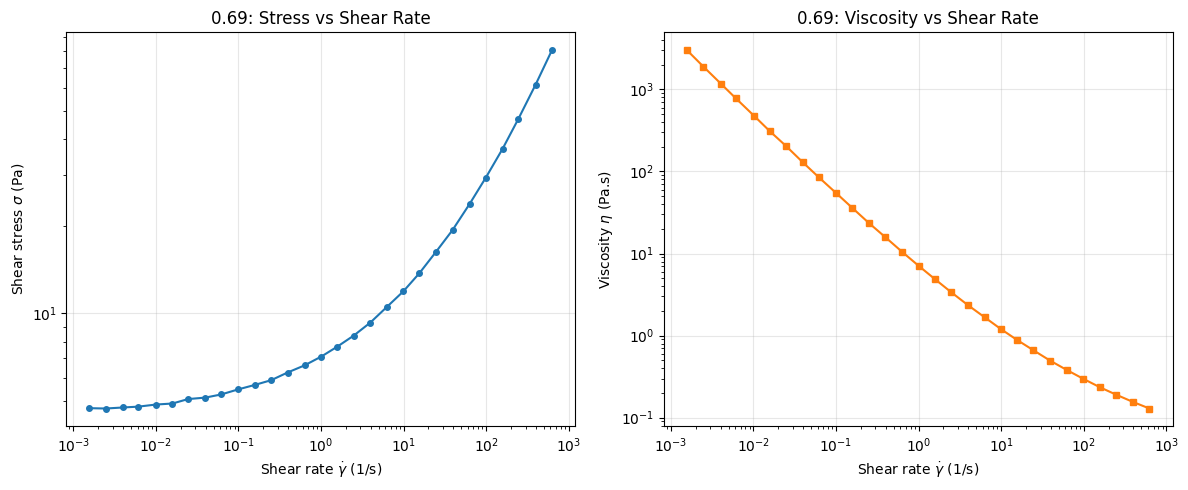

In [7]:
if not SKIP_HEAVY_PLOTS:
    output_paths = create_output_directories("flow_curve")
    
    for v in validations:
        if v.passed and "gamma_dot" in v.derived_quantities:
            file_name = Path(v.file_path).stem
            save_path = output_paths["plots"] / f"{file_name}_flow_curve.png" if SAVE_ARTIFACTS else None
            
            fig = plot_flow_curve(
                v.derived_quantities["gamma_dot"],
                v.derived_quantities["stress"],
                v.derived_quantities["eta"],
                save_path=save_path,
                title=file_name,
            )
            plt.show()
else:
    # Quick plot of first valid file
    for v in validations:
        if v.passed and "gamma_dot" in v.derived_quantities:
            fig = plot_flow_curve(
                v.derived_quantities["gamma_dot"],
                v.derived_quantities["stress"],
                v.derived_quantities["eta"],
                title=Path(v.file_path).stem,
            )
            plt.show()
            break

## E) Validation Summary

In [8]:
print_validation_summary(validations)


Validation Summary
File                                     Status     Passed   Failed  
--------------------------------------------------------------------------------
0.69.csv                                 PASS       6        0       
0.70.csv                                 PASS       6        0       
--------------------------------------------------------------------------------
TOTAL                                    ALL PASS   12       0       


## F) Export Artifacts

In [9]:
if SAVE_ARTIFACTS:
    output_paths = create_output_directories("flow_curve")
    
    # Save validation report
    report = {
        "protocol": "flow_curve",
        "mode": MODE,
        "n_files_validated": len(validations),
        "all_passed": all(v.passed for v in validations),
        "validations": validations,
    }
    
    report_path = output_paths["plots"].parent / "validation_report.json"
    write_validation_report(report, report_path)
    print(f"Validation report saved to: {report_path}")
    
    # Save derived quantities
    for v in validations:
        if v.passed and "gamma_dot" in v.derived_quantities:
            file_name = Path(v.file_path).stem
            df = pd.DataFrame({
                "gamma_dot": v.derived_quantities["gamma_dot"],
                "stress": v.derived_quantities["stress"],
                "eta": v.derived_quantities["eta"],
            })
            df.to_csv(output_paths["derived_quantities"] / f"{file_name}_derived.csv", index=False)
    
    print(f"Derived quantities saved to: {output_paths['derived_quantities']}")
else:
    print("Artifacts not saved (FAST mode). Set MODE='FULL' to save.")

Artifacts not saved (FAST mode). Set MODE='FULL' to save.


## Summary

This notebook validated flow curve data for:
- Data integrity (no NaN/Inf)
- Physical constraints (positive shear rate, non-negative stress)
- Rheological behavior (shear-thinning detection)

**Next steps:**
- Run in FULL mode to process all files
- Review any FAIL results for data quality issues